In [1]:
!git clone https://github.com/yhenon/pytorch-retinanet.git


Cloning into 'pytorch-retinanet'...
remote: Enumerating objects: 232, done.
remote: Total 232 (delta 0), reused 0 (delta 0), pack-reused 232 (from 2)
Receiving objects: 100% (232/232), 1.02 MiB | 14.50 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [2]:
!apt-get install tk-dev python-tk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tk-dev is already the newest version (8.6.11+1build2).
The following additional packages will be installed:
  libpython2-stdlib libpython2.7-minimal libpython2.7-stdlib python2 python2-minimal python2.7
  python2.7-minimal
Suggested packages:
  tix python-tk-dbg python2-doc python2.7-doc binfmt-support
The following NEW packages will be installed:
  libpython2-stdlib libpython2.7-minimal libpython2.7-stdlib python-tk python2 python2-minimal
  python2.7 python2.7-minimal
0 upgraded, 8 newly installed, 0 to remove and 122 not upgraded.
Need to get 4,037 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libpython2.7-minimal amd64 2.7.18-13ubuntu1.5 [347 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python2.7-minimal amd64 2.7.18-13ubuntu1.5 [1,400 kB]
Get:3 http://ar

In [3]:
!pip install pandas
!pip install pycocotools
!pip install opencv-python
!pip install requests


In [4]:
import os, shutil

# Buat folder struktur sesuai COCO
for split in ['train', 'valid', 'test']:
    os.makedirs(f"/kaggle/working/images/{split}", exist_ok=True)

# Copy gambar train, valid, test
for split in ['train', 'valid', 'test']:
    src_dir = f"/kaggle/input/mangrovev2/mangrovev2/{split}"
    dst_dir = f"/kaggle/working/images/{split}"
    if os.path.exists(src_dir):
        for fname in os.listdir(src_dir):
            shutil.copy(f"{src_dir}/{fname}", f"{dst_dir}/{fname}")

# Copy annotation file
shutil.copytree("/kaggle/input/mangrovev2/mangrovev2/annotations", "/kaggle/working/annotations", dirs_exist_ok=True)


'/kaggle/working/annotations'

In [5]:
# import json

# # Daftar path file
# paths = [
#     "/kaggle/working/annotations/instances_train.json",
#     "/kaggle/working/annotations/instances_valid.json",
#     "/kaggle/working/annotations/instances_test.json"
# ]

# for path in paths:
#     with open(path, "r") as f:
#         data = json.load(f)

#     # Hapus kategori dengan id 0
#     original_len = len(data["categories"])
#     data["categories"] = [cat for cat in data["categories"] if cat["id"] != 0]
#     removed = original_len - len(data["categories"])

#     with open(path, "w") as f:
#         json.dump(data, f, indent=4)

#     print(f"{removed} kategori dihapus dari {path}")


In [6]:
# import json
# import os

# def fix_annotations(file_path, output_path):
#     with open(file_path, 'r') as f:
#         data = json.load(f)

#     # Hapus kategori dengan id == 0 (1-QDa5-FSKD)
#     data['categories'] = [cat for cat in data['categories'] if cat['id'] != 0]

#     # Buat mapping baru dari id lama ke id baru
#     id_mapping = {old['id']: new_id for new_id, old in enumerate(data['categories'])}
#     for i, cat in enumerate(data['categories']):
#         cat['id'] = i  # Set ID baru 0,1,2

#     # Update annotations category_id
#     fixed_annotations = []
#     for ann in data['annotations']:
#         if ann['category_id'] == 0:
#             continue  # Hapus yang 1-QDa5-FSKD
#         ann['category_id'] = id_mapping[ann['category_id']]
#         fixed_annotations.append(ann)

#     data['annotations'] = fixed_annotations

#     # Simpan ke file baru
#     with open(output_path, 'w') as f:
#         json.dump(data, f)

# # Jalankan untuk semua file
# base_path = "/kaggle/working/annotations"
# for split in ["train", "valid", "test"]:
#     input_file = os.path.join(base_path, f"instances_{split}.json")
#     output_file = os.path.join(base_path, f"instances_{split}_cleaned.json")
#     fix_annotations(input_file, output_file)
#     print(f"✓ Cleaned: {output_file}")


In [7]:
# %%writefile /kaggle/working/pytorch-retinanet/train.py
# import argparse
# import collections
# import numpy as np
# import torch
# import torch.optim as optim
# from torchvision import transforms
# from retinanet import model
# from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, Normalizer
# from torch.utils.data import DataLoader
# from retinanet import coco_eval
# from retinanet import csv_eval
# import matplotlib.pyplot as plt
# import json

# train_losses = []
# val_maps = []

# print('CUDA available: {}'.format(torch.cuda.is_available()))

# def main(args=None):
#     parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

#     parser.add_argument('--dataset', help='Dataset type, must be one of csv or coco.')
#     parser.add_argument('--coco_path', help='Path to COCO directory')
#     parser.add_argument('--csv_train', help='Path to file containing training annotations')
#     parser.add_argument('--csv_classes', help='Path to file containing class list')
#     parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional)')
#     parser.add_argument('--depth', help='Resnet depth', type=int, default=50)
#     parser.add_argument('--epochs', help='Number of epochs', type=int, default=100)

#     parser = parser.parse_args(args)

#     # Dataset
#     if parser.dataset == 'coco':
#         dataset_train = CocoDataset(parser.coco_path, set_name='train', transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
#         dataset_val = CocoDataset(parser.coco_path, set_name='valid', transform=transforms.Compose([Normalizer(), Resizer()]))
#     elif parser.dataset == 'csv':
#         dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes, transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
#         dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes, transform=transforms.Compose([Normalizer(), Resizer()])) if parser.csv_val else None
#     else:
#         raise ValueError('Dataset type not understood (must be csv or coco)')

#     # DataLoader
#     sampler = AspectRatioBasedSampler(dataset_train, batch_size=2, drop_last=False)
#     dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)
#     dataloader_val = None
#     if dataset_val:
#         sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
#         dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)

#     # Model
#     retinanet = {
#         18: model.resnet18,
#         34: model.resnet34,
#         50: model.resnet50,
#         101: model.resnet101,
#         152: model.resnet152
#     }[parser.depth](num_classes=dataset_train.num_classes(), pretrained=True)

#     if torch.cuda.is_available():
#         retinanet = torch.nn.DataParallel(retinanet).cuda()
#     else:
#         retinanet = torch.nn.DataParallel(retinanet)

#     retinanet.training = True
#     optimizer = optim.Adam(retinanet.parameters(), lr=1e-5)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

#     loss_hist = collections.deque(maxlen=500)
#     retinanet.train()
#     retinanet.module.freeze_bn()

#     print('Num training images: {}'.format(len(dataset_train)))

#     best_map = -1  # best mAP so far

#     for epoch_num in range(parser.epochs):
#         retinanet.train()
#         retinanet.module.freeze_bn()

#         epoch_loss = []

#         for iter_num, data in enumerate(dataloader_train):
#             try:
#                 optimizer.zero_grad()
#                 if torch.cuda.is_available():
#                     classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot']])
#                 else:
#                     classification_loss, regression_loss = retinanet([data['img'].float(), data['annot']])

#                 classification_loss = classification_loss.mean()
#                 regression_loss = regression_loss.mean()
#                 loss = classification_loss + regression_loss

#                 if bool(loss == 0):
#                     continue

#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)
#                 optimizer.step()

#                 loss_hist.append(float(loss))
#                 epoch_loss.append(float(loss))

#                 print('Epoch: {} | Iteration: {} | Cls loss: {:1.5f} | Reg loss: {:1.5f} | Running loss: {:1.5f}'.format(
#                     epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))

#                 del classification_loss, regression_loss

#             except Exception as e:
#                 print(f"Error: {e}")
#                 continue

#         train_losses.append(np.mean(epoch_loss))

#         # Evaluate mAP
#         if parser.dataset == 'coco':
#             print('Evaluating COCO dataset...')
#             mAP = coco_eval.evaluate_coco(dataset_val, retinanet)
#         elif parser.dataset == 'csv' and parser.csv_val:
#             print('Evaluating CSV dataset...')
#             mAP = csv_eval.evaluate(dataset_val, retinanet)
#         else:
#             mAP = 0.0  # dummy if no val

#         mAP = mAP if isinstance(mAP, float) else 0.0
#         val_maps.append(mAP)
#         print(f"Epoch {epoch_num} - mAP: {mAP:.4f}")

#         # Save best model
#         if mAP > best_map:
#             best_map = mAP
#             torch.save(retinanet.module, 'best_model.pt')
#             print(f"==> Best model saved at epoch {epoch_num} with mAP: {best_map:.4f}")

#         scheduler.step(np.mean(epoch_loss))

#     # Save final model
#     retinanet.eval()
#     torch.save(retinanet, 'model_final.pt')
#     print("Final model saved as model_final.pt")

#     # Plot training loss and mAP
#     epochs = list(range(1, len(train_losses) + 1))
#     plt.plot(epochs, train_losses, label='Train Loss')
#     plt.plot(epochs, val_maps, label='Val mAP')
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss / mAP")
#     plt.title("Training Loss & Validation mAP over Epochs")
#     plt.legend()
#     plt.grid(True)
#     plt.savefig("loss_map_curve.png")
#     plt.show()

#     # Save to JSON
#     with open("metrics_log.json", "w") as f:
#         json.dump({"train_losses": train_losses, "val_maps": val_maps}, f)

# if __name__ == '__main__':
#     main()


In [8]:
%%writefile /kaggle/working/pytorch-retinanet/train.py

import argparse
import collections
import csv
from datetime import datetime
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms
from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, Normalizer
from torch.utils.data import DataLoader
from retinanet import coco_eval
from retinanet import csv_eval

assert torch.__version__.split('.')[0] == '1'

print('CUDA available: {}'.format(torch.cuda.is_available()))

def main(args=None):
    parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

    parser.add_argument('--dataset', help='Dataset type, must be one of csv or coco.')
    parser.add_argument('--coco_path', help='Path to COCO directory')
    parser.add_argument('--csv_train', help='Path to file containing training annotations (see readme)')
    parser.add_argument('--csv_classes', help='Path to file containing class list (see readme)')
    parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional, see readme)')
    parser.add_argument('--depth', help='Resnet depth, must be one of 18, 34, 50, 101, 152', type=int, default=50)
    parser.add_argument('--epochs', help='Number of epochs', type=int, default=100)

    parser = parser.parse_args(args)

    if parser.dataset == 'coco':
        if parser.coco_path is None:
            raise ValueError('Must provide --coco_path when training on COCO')
        dataset_train = CocoDataset(parser.coco_path, set_name='train2017',
                                    transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
        dataset_val = CocoDataset(parser.coco_path, set_name='val2017',
                                  transform=transforms.Compose([Normalizer(), Resizer()]))
    elif parser.dataset == 'csv':
        if parser.csv_train is None or parser.csv_classes is None:
            raise ValueError('Must provide --csv_train and --csv_classes when training on CSV')
        dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                                   transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
        if parser.csv_val is None:
            dataset_val = None
            print('No validation annotations provided.')
        else:
            dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes,
                                     transform=transforms.Compose([Normalizer(), Resizer()]))
    else:
        raise ValueError('Dataset type not understood (must be csv or coco)')

    sampler = AspectRatioBasedSampler(dataset_train, batch_size=2, drop_last=False)
    dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)

    if dataset_val is not None:
        sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
        dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)

    if parser.depth == 18:
        retinanet = model.resnet18(num_classes=dataset_train.num_classes(), pretrained=True)
    elif parser.depth == 34:
        retinanet = model.resnet34(num_classes=dataset_train.num_classes(), pretrained=True)
    elif parser.depth == 50:
        retinanet = model.resnet50(num_classes=dataset_train.num_classes(), pretrained=True)
    elif parser.depth == 101:
        retinanet = model.resnet101(num_classes=dataset_train.num_classes(), pretrained=True)
    elif parser.depth == 152:
        retinanet = model.resnet152(num_classes=dataset_train.num_classes(), pretrained=True)
    else:
        raise ValueError('Unsupported model depth')

    use_gpu = torch.cuda.is_available()
    if use_gpu:
        retinanet = torch.nn.DataParallel(retinanet).cuda()
    else:
        retinanet = torch.nn.DataParallel(retinanet)

    retinanet.training = True
    optimizer = optim.Adam(retinanet.parameters(), lr=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
    loss_hist = collections.deque(maxlen=500)

    best_mAP = 0
    best_loss = float('inf')

    retinanet.train()
    retinanet.module.freeze_bn()

    print('Num training images: {}'.format(len(dataset_train)))

    log_file = open('training_log.csv', 'w', newline='')
    log_writer = csv.writer(log_file)
    log_writer.writerow(['datetime', 'epoch', 'iteration', 'classification_loss', 'regression_loss', 'total_loss'])

    for epoch_num in range(parser.epochs):
        retinanet.train()
        retinanet.module.freeze_bn()

        epoch_loss = []

        for iter_num, data in enumerate(dataloader_train):
            try:
                optimizer.zero_grad()

                if use_gpu:
                    classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot']])
                else:
                    classification_loss, regression_loss = retinanet([data['img'].float(), data['annot']])

                classification_loss = classification_loss.mean()
                regression_loss = regression_loss.mean()

                loss = classification_loss + regression_loss
                if bool(loss == 0):
                    continue

                loss.backward()
                torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)
                optimizer.step()

                loss_hist.append(float(loss))
                epoch_loss.append(float(loss))

                log_writer.writerow([
                    datetime.now().isoformat(),
                    epoch_num,
                    iter_num,
                    float(classification_loss),
                    float(regression_loss),
                    float(loss)
                ])
                log_file.flush()

                print('Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                    epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))

                del classification_loss
                del regression_loss
            except Exception as e:
                print(e)
                continue

        mean_epoch_loss = np.mean(epoch_loss)
        if mean_epoch_loss < best_loss:
            best_loss = mean_epoch_loss
            torch.save(retinanet.module, 'best_loss_model.pt')
            print(f"Best loss model saved at epoch {epoch_num} with loss: {best_loss:.5f}")

        if parser.dataset == 'coco':
            print('Evaluating dataset')
            evaluation = coco_eval.evaluate_coco(dataset_val, retinanet)
            if evaluation:
                with open('map_log.csv', 'a') as f:
                    f.write(f"{epoch_num},{evaluation['mAP']:.4f},{evaluation['AP50']:.4f},{evaluation['AP75']:.4f}\n")
                if evaluation['mAP'] > best_mAP:
                    best_mAP = evaluation['mAP']
                    torch.save(retinanet.module, 'best_model.pt')
                    print(f"Best mAP model saved at epoch {epoch_num} with mAP: {best_mAP:.4f}")

        elif parser.dataset == 'csv' and parser.csv_val is not None:
            print('Evaluating dataset')
            mAP = csv_eval.evaluate(dataset_val, retinanet)
            if mAP > best_mAP:
                best_mAP = mAP
                torch.save(retinanet.module, 'best_model.pt')
                print(f"Best mAP model saved at epoch {epoch_num} with mAP: {best_mAP:.4f}")

        scheduler.step(mean_epoch_loss)

    retinanet.eval()
    torch.save(retinanet, 'model_final.pt')
    log_file.close()

if __name__ == '__main__':
    main()


Overwriting /kaggle/working/pytorch-retinanet/train.py


In [9]:
%%writefile /kaggle/working/pytorch-retinanet/retinanet/coco_eval.py

from pycocotools.cocoeval import COCOeval
import json
import torch


def evaluate_coco(dataset, model, threshold=0.05):
    
    model.eval()
    
    with torch.no_grad():

        # start collecting results
        results = []
        image_ids = []

        for index in range(len(dataset)):
            data = dataset[index]
            scale = data['scale']

            # run network
            if torch.cuda.is_available():
                scores, labels, boxes = model(data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0))
            else:
                scores, labels, boxes = model(data['img'].permute(2, 0, 1).float().unsqueeze(dim=0))
            scores = scores.cpu()
            labels = labels.cpu()
            boxes  = boxes.cpu()

            # correct boxes for image scale
            boxes /= scale

            if boxes.shape[0] > 0:
                # change to (x, y, w, h) (MS COCO standard)
                boxes[:, 2] -= boxes[:, 0]
                boxes[:, 3] -= boxes[:, 1]

                # compute predicted labels and scores
                #for box, score, label in zip(boxes[0], scores[0], labels[0]):
                for box_id in range(boxes.shape[0]):
                    score = float(scores[box_id])
                    label = int(labels[box_id])
                    box = boxes[box_id, :]

                    # scores are sorted, so we can break
                    if score < threshold:
                        break

                    # append detection for each positively labeled class
                    image_result = {
                        'image_id'    : dataset.image_ids[index],
                        'category_id' : dataset.label_to_coco_label(label),
                        'score'       : float(score),
                        'bbox'        : box.tolist(),
                    }

                    # append detection to results
                    results.append(image_result)

            # append image to list of processed images
            image_ids.append(dataset.image_ids[index])

            # print progress
            print('{}/{}'.format(index, len(dataset)), end='\r')

        if not len(results):
            return

        # write output
        json.dump(results, open('{}_bbox_results.json'.format(dataset.set_name), 'w'), indent=4)

        # load results in COCO evaluation tool
        coco_true = dataset.coco
        coco_pred = coco_true.loadRes('{}_bbox_results.json'.format(dataset.set_name))

        # run COCO evaluation
        coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
        coco_eval.params.imgIds = image_ids
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        stats = coco_eval.stats  # [mAP, AP50, AP75, ...]
        model.train()

        return {
            'mAP': stats[0],
            'AP50': stats[1],
            'AP75': stats[2],
            'AP_small': stats[3],
            'AP_medium': stats[4],
            'AP_large': stats[5]
        }


Overwriting /kaggle/working/pytorch-retinanet/retinanet/coco_eval.py


In [10]:
# Ganti 'train2017' dan 'val2017' jadi 'train' dan 'valid'
path = "pytorch-retinanet/train.py"

with open(path, "r") as f:
    lines = f.readlines()

lines = [line.replace("train2017", "train").replace("val2017", "valid") for line in lines]

with open(path, "w") as f:
    f.writelines(lines)



In [11]:
# Buka dan baca file train.py
with open('pytorch-retinanet/train.py', 'r') as file:
    lines = file.readlines()

# Hapus baris yang mengandung "assert torch.__version__..."
lines = [line for line in lines if 'assert torch.__version__' not in line]

# Tulis ulang file tanpa baris tersebut
with open('pytorch-retinanet/train.py', 'w') as file:
    file.writelines(lines)


In [12]:
# Gabungan pengganti batch_size dan learning rate
train_file_path = "/kaggle/working/pytorch-retinanet/train.py"

with open(train_file_path, "r") as file:
    lines = file.readlines()

new_lines = []
for line in lines:
    # Ganti batch_size training dan validasi
    if "batch_size=2" in line:
        line = line.replace("batch_size=2", "batch_size=16")
    elif "batch_size=1" in line:
        line = line.replace("batch_size=1", "batch_size=16")
    
    # # Ganti learning rate
    # if "optimizer = optim.Adam" in line and "lr=" in line:
    #     line = line.replace("lr=1e-5", "lr=1e-5")
    
    new_lines.append(line)

with open(train_file_path, "w") as file:
    file.writelines(new_lines)

print("✅ Batch size diubah ke 16 dan learning rate ke 1e-5.")


✅ Batch size diubah ke 16 dan learning rate ke 1e-5.


In [13]:
!python /kaggle/working/pytorch-retinanet/train.py --dataset coco --coco_path /kaggle/working --depth 50 --epochs 200


CUDA available: True
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to ./resnet50-19c8e357.pth
100%|███████████████████████████████████████| 97.8M/97.8M [00:00<00:00, 305MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Num training images: 830
Epoch: 0 | Iteration: 0 | Classification loss: 1.14175 | Regression loss: 1.07244 | Running loss: 2.21420
Epoch: 0 | Iteration: 1 | Classification loss: 1.31916 | Regression loss: 0.99878 | Running loss: 2.26607
Epoch: 0 | Iteration: 2 | Classification loss: 1.11483 | Regression loss: 1.04829 | Running loss: 2.23176
Epoch: 0 | Iteration: 3 | Classification loss: 1.21536 | Regression loss: 0.97150 | Running loss

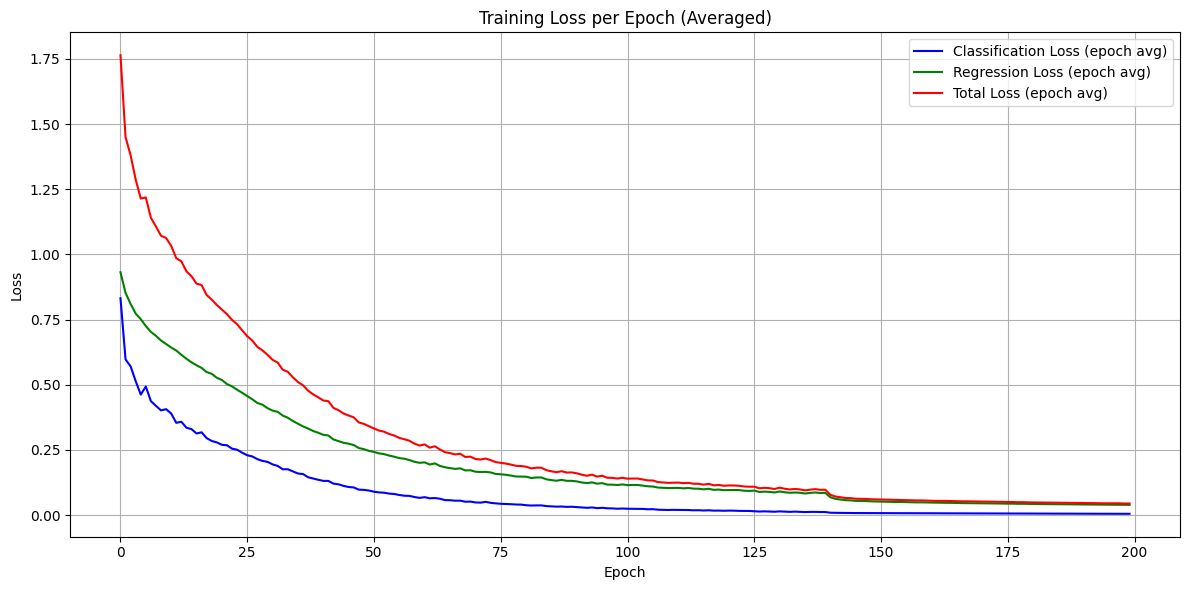

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Baca CSV log
log = pd.read_csv('/kaggle/working/training_log.csv')


# ========== 2. Rerata Loss per Epoch ==========
epoch_grouped = log.groupby('epoch').mean(numeric_only=True)

plt.figure(figsize=(12, 6))
plt.plot(epoch_grouped.index, epoch_grouped['classification_loss'], label='Classification Loss (epoch avg)', color='blue')
plt.plot(epoch_grouped.index, epoch_grouped['regression_loss'], label='Regression Loss (epoch avg)', color='green')
plt.plot(epoch_grouped.index, epoch_grouped['total_loss'], label='Total Loss (epoch avg)', color='red')

plt.title('Training Loss per Epoch (Averaged)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


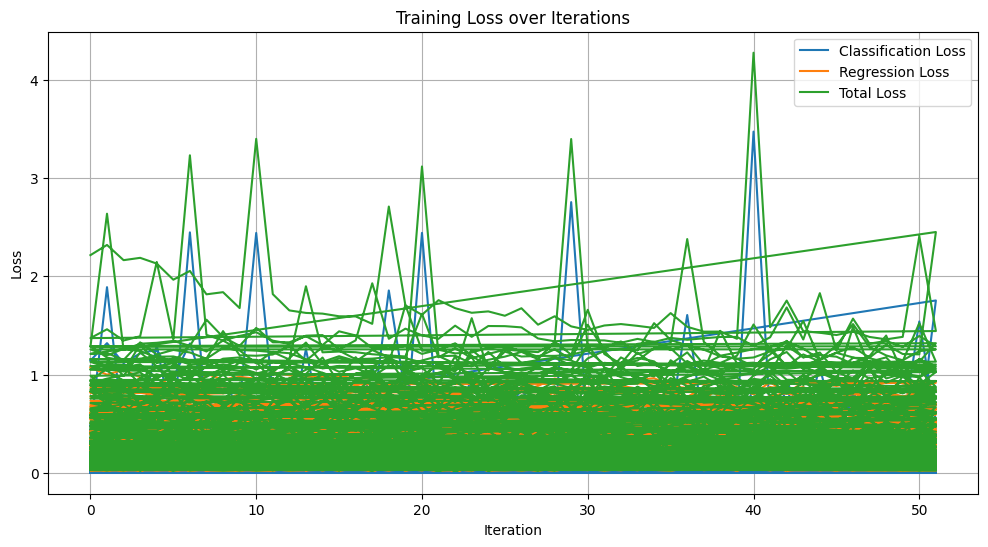

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Baca CSV
log = pd.read_csv('/kaggle/working/training_log.csv')

# Buat plot loss
plt.figure(figsize=(12, 6))
plt.plot(log['iteration'], log['classification_loss'], label='Classification Loss')
plt.plot(log['iteration'], log['regression_loss'], label='Regression Loss')
plt.plot(log['iteration'], log['total_loss'], label='Total Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.grid(True)
plt.show()


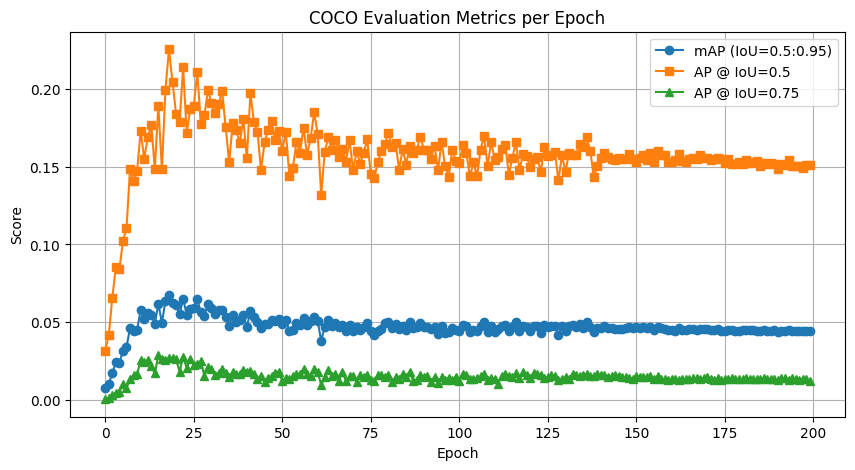

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/working/map_log.csv', header=None, names=['epoch', 'mAP', 'AP50', 'AP75'])

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['mAP'], label='mAP (IoU=0.5:0.95)', marker='o')
plt.plot(df['epoch'], df['AP50'], label='AP @ IoU=0.5', marker='s')
plt.plot(df['epoch'], df['AP75'], label='AP @ IoU=0.75', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('COCO Evaluation Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
%%writefile /kaggle/working/pytorch-retinanet/coco_validation.py

import argparse
import torch
from torchvision import transforms

from retinanet.dataloader import CocoDataset, Resizer, Normalizer
from retinanet import coco_eval

print('CUDA available: {}'.format(torch.cuda.is_available()))

def main(args=None):
    parser = argparse.ArgumentParser(description='COCO evaluation script for RetinaNet.')
    parser.add_argument('--coco_path', help='Path to COCO directory')
    parser.add_argument('--model_path', help='Path to model (.pt file)', type=str)

    parser = parser.parse_args(args)

    # Load validation dataset
    dataset_val = CocoDataset(parser.coco_path, set_name='val2017',
                              transform=transforms.Compose([Normalizer(), Resizer()]))

    # Load full model (not just state_dict)
    if torch.cuda.is_available():
        device = torch.device('cuda')
        model = torch.load(parser.model_path, map_location=device)
        model = torch.nn.DataParallel(model).cuda()
    else:
        device = torch.device('cpu')
        model = torch.load(parser.model_path, map_location=device)
        model = torch.nn.DataParallel(model)

    model.eval()
    model.module.freeze_bn()

    # Evaluate using COCO API
    coco_eval.evaluate_coco(dataset_val, model)

if __name__ == '__main__':
    main()


Overwriting /kaggle/working/pytorch-retinanet/coco_validation.py


In [18]:
# Overwrite coco_validation.py dengan versi yang kompatibel dengan PyTorch 2.x
coco_validation_code = """
import argparse
import torch
from torchvision import transforms

from retinanet import model
from retinanet.dataloader import CocoDataset, Resizer, Normalizer
from retinanet import coco_eval

print('CUDA available: {}'.format(torch.cuda.is_available()))


def main(args=None):
    parser = argparse.ArgumentParser(description='Simple evaluation script for RetinaNet.')

    parser.add_argument('--coco_path', help='Path to COCO directory')
    parser.add_argument('--model_path', help='Path to model', type=str)

    parser = parser.parse_args(args)

    dataset_val = CocoDataset(parser.coco_path, set_name='val2017',
                              transform=transforms.Compose([Normalizer(), Resizer()]))

    # Load the entire model directly (because it was saved using torch.save(model))
    retinanet = torch.load(parser.model_path)

    if torch.cuda.is_available():
        retinanet = retinanet.cuda()

    retinanet.training = False
    retinanet.eval()

    # Freeze batch norm layers
    if hasattr(retinanet, 'module'):
        retinanet.module.freeze_bn()
    else:
        retinanet.freeze_bn()

    coco_eval.evaluate_coco(dataset_val, retinanet)


if __name__ == '__main__':
    main()
"""

# Simpan ke file
with open('/kaggle/working/pytorch-retinanet/coco_validation.py', 'w') as f:
    f.write(coco_validation_code)

print("✅ coco_validation.py berhasil diperbarui!")


✅ coco_validation.py berhasil diperbarui!


In [19]:
# Baca file coco_validation.py
with open('/kaggle/working/pytorch-retinanet/coco_validation.py', 'r') as file:
    code = file.read()

# Ganti bagian 'val2017' dengan 'valid'
modified_code = code.replace("set_name='val2017'", "set_name='valid'")

# Simpan file dengan perubahan
with open('/kaggle/working/pytorch-retinanet/coco_validation.py', 'w') as file:
    file.write(modified_code)

# Cek apakah perubahan sudah berhasil
print("Perubahan telah diterapkan pada file coco_validation.py.")


Perubahan telah diterapkan pada file coco_validation.py.


In [ ]:
updated_code = '''
from pycocotools.cocoeval import COCOeval
import json
import torch


def evaluate_coco(dataset, model, threshold=0.05):
    model.eval()
    
    with torch.no_grad():
        results = []
        image_ids = []

        for index in range(len(dataset)):
            data = dataset[index]
            scale = data['scale']

            if torch.cuda.is_available():
                scores, labels, boxes = model(data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0))
            else:
                scores, labels, boxes = model(data['img'].permute(2, 0, 1).float().unsqueeze(dim=0))
            
            scores = scores.cpu()
            labels = labels.cpu()
            boxes = boxes.cpu()
            boxes /= scale

            if boxes.shape[0] > 0:
                boxes[:, 2] -= boxes[:, 0]
                boxes[:, 3] -= boxes[:, 1]

                for box_id in range(boxes.shape[0]):
                    score = float(scores[box_id])
                    label = int(labels[box_id])
                    box = boxes[box_id, :]

                    if score < threshold:
                        break

                    image_result = {
                        'image_id': dataset.image_ids[index],
                        'category_id': dataset.label_to_coco_label(label),
                        'score': float(score),
                        'bbox': box.tolist(),
                    }

                    results.append(image_result)

            image_ids.append(dataset.image_ids[index])
            print('{}/{}'.format(index, len(dataset)), end='\\r')

        if not len(results):
            return

        result_file = f'{dataset.set_name}_bbox_results.json'
        json.dump(results, open(result_file, 'w'), indent=4)

        coco_true = dataset.coco
        coco_pred = coco_true.loadRes(result_file)

        coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
        coco_eval.params.imgIds = image_ids
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # Tambahan: cetak AP per class
        print('\\nPer-class AP:')
        cat_ids = coco_true.getCatIds()
        categories = coco_true.loadCats(cat_ids)
        precisions = coco_eval.eval['precision']  # [TxRxKxAxM]

        for idx, cat in enumerate(categories):
            precision = precisions[:, :, idx, 0, 2]
            precision = precision[precision > -1]
            ap = precision.mean() if precision.size else float('nan')
            print(f"{cat['name']:>20s}: {ap:.3f}")

        model.train()
'''

# Tulis file baru ke lokasi yang sesuai
eval_path = '/kaggle/working/pytorch-retinanet/retinanet/coco_eval.py'

with open(eval_path, 'w') as f:
    f.write(updated_code)

print(f"✅ coco_eval.py berhasil diperbarui di {eval_path}")


In [23]:
!python /kaggle/working/pytorch-retinanet/coco_validation.py \
  --coco_path /kaggle/working \
  --model_path /kaggle/working/best_model.pt

CUDA available: True
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/kaggle/working/pytorch-retinanet/coco_validation.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/tmp/ipykernel_31/4176757385.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retinanet = torch.load('/kaggle/working/model_final.pt')


Elapsed time (img 1): 0.88s
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 0.98
rhizophora tree: 0.98
rhizophora tree: 0.93
rhizophora tree: 0.92
rhizophora tree: 0.91
rhizophora tree: 0.81
rhizophora tree: 0.79
rhizophora tree: 0.66
rhizophora tree: 0.66
rhizophora tree: 0.62
rhizophora tree: 0.61
rhizophora tree: 0.58
rhizophora tree: 0.53


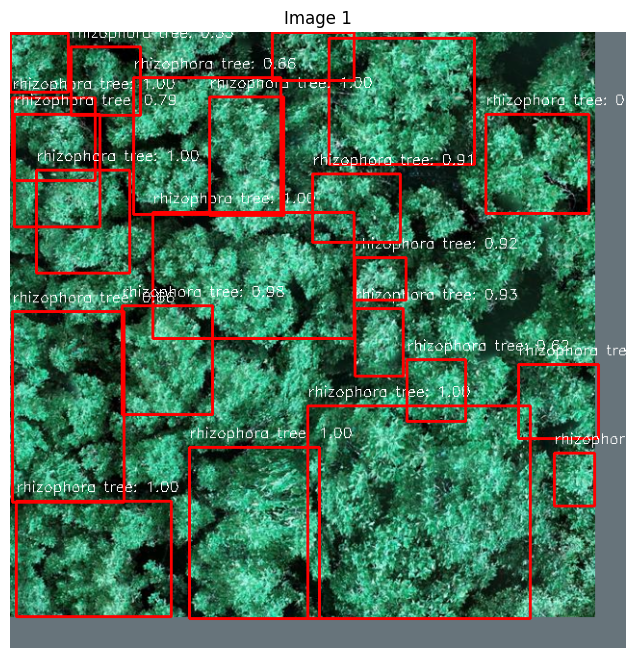

Elapsed time (img 2): 0.13s
nypa: 1.00
nypa: 1.00
nypa: 1.00
rhizophora tree: 1.00
rhizophora tree: 0.92
rhizophora tree: 0.79
rhizophora tree: 0.55


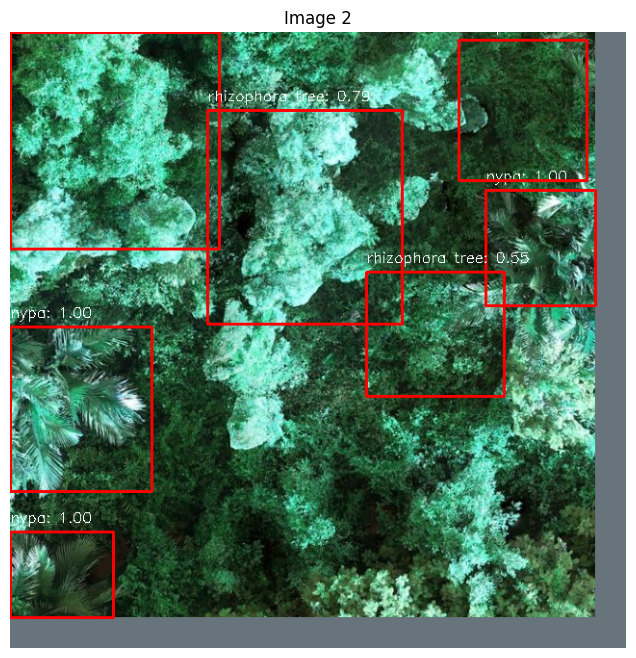

Elapsed time (img 3): 0.10s
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 0.99
rhizophora tree: 0.98
rhizophora tree: 0.96
rhizophora tree: 0.95
rhizophora tree: 0.95
rhizophora tree: 0.94
rhizophora tree: 0.88
rhizophora tree: 0.84
rhizophora tree: 0.73
rhizophora tree: 0.69
rhizophora tree: 0.50


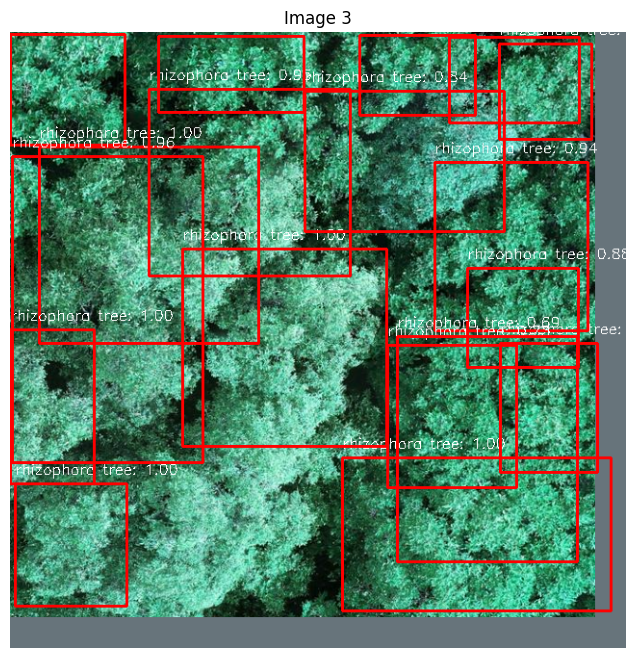

Elapsed time (img 4): 0.11s
rhizophora tree: 1.00
rhizophora tree: 0.99
rhizophora tree: 0.99
rhizophora tree: 0.96
rhizophora tree: 0.94
rhizophora tree: 0.80
rhizophora tree: 0.77
rhizophora tree: 0.69
rhizophora tree: 0.66


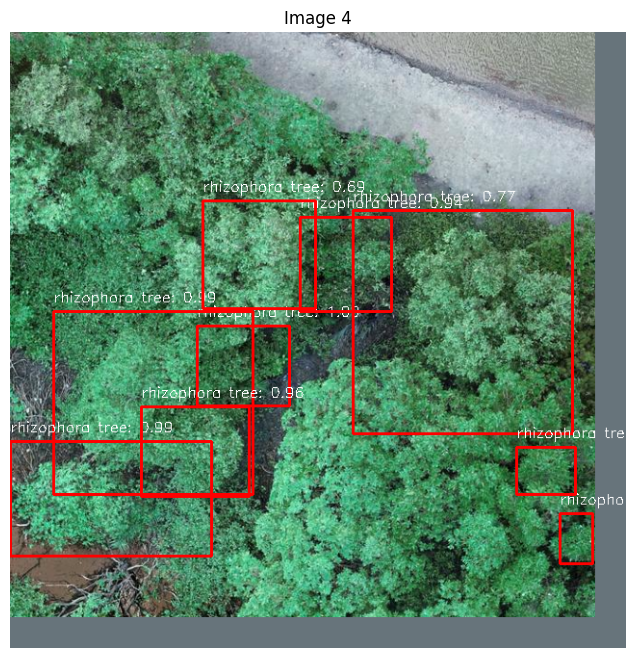

Elapsed time (img 5): 0.11s
avicennia tree: 0.63
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 1.00
rhizophora tree: 0.82
rhizophora tree: 0.79
rhizophora tree: 0.74
rhizophora tree: 0.50


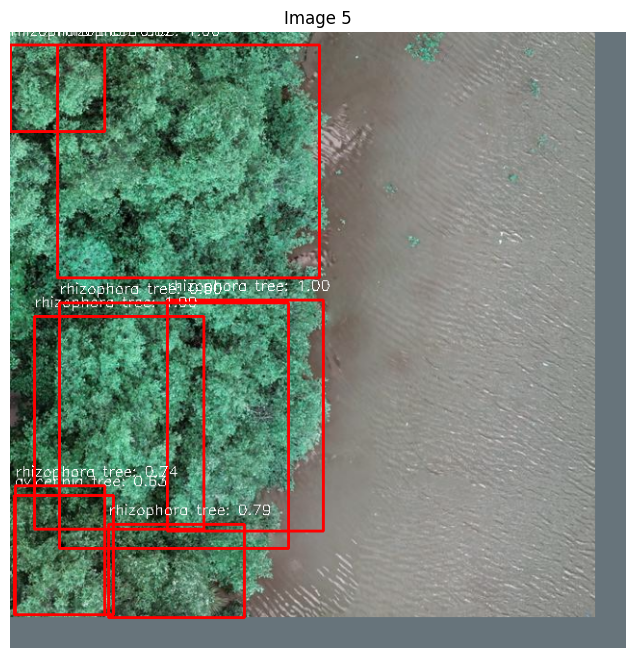

In [24]:
import sys
sys.path.append('/kaggle/working/pytorch-retinanet')

import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader
from torchvision import transforms
from retinanet.dataloader import CocoDataset, collater, Resizer, AspectRatioBasedSampler, Normalizer, UnNormalizer

# Dataset dan model
dataset_val = CocoDataset('/kaggle/working', set_name='test', transform=transforms.Compose([Normalizer(), Resizer()]))
sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
dataloader_val = DataLoader(dataset_val, num_workers=1, collate_fn=collater, batch_sampler=sampler_val)

retinanet = torch.load('/kaggle/working/model_final.pt')
retinanet = retinanet.cuda()
retinanet.eval()

unnormalize = UnNormalizer()

def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# Tampilkan 5 gambar
num_images = 5
count = 0

for idx, data in enumerate(dataloader_val):
    if count >= num_images:
        break

    with torch.no_grad():
        st = time.time()
        scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
        print(f'Elapsed time (img {count+1}): {time.time() - st:.2f}s')
        idxs = np.where(scores.cpu() > 0.5)

        img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()
        img[img < 0] = 0
        img[img > 255] = 255
        img = np.transpose(img, (1, 2, 0)).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for j in range(idxs[0].shape[0]):
            bbox = transformed_anchors[idxs[0][j], :]
            score = scores[idxs[0][j]].cpu().item()
            x1, y1, x2, y2 = map(int, bbox)
            label_idx = int(classification[idxs[0][j]])
            label_name = dataset_val.labels[label_idx]
            caption = f"{label_name}: {score:.2f}"
            draw_caption(img, (x1, y1, x2, y2), caption)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            print(caption)

        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {count + 1}')
        plt.show()

        count += 1


In [ ]:
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################

In [25]:
import torch
from retinanet.model import resnet50  # <-- gunakan factory function ini

print("PyTorch:", torch.__version__)
print("resnet50 factory:", resnet50)


PyTorch: 2.5.1+cu124
resnet50 factory: <function resnet50 at 0x7f80f26b8680>


In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from retinanet.dataloader import CocoDataset, Resizer, Normalizer
from retinanet import model


In [32]:
# Path ke model dan dataset COCO (sesuaikan)
MODEL_PATH = '/kaggle/working/best_model.pt'
COCO_PATH = '/kaggle/working'

# Load model
retinanet = torch.load(MODEL_PATH)
retinanet = torch.nn.DataParallel(retinanet)
retinanet.eval()

# Load dataset validation
dataset = CocoDataset(COCO_PATH, set_name='valid',
                      transform=transforms.Compose([Normalizer(), Resizer()]))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/tmp/ipykernel_31/823249757.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retinanet = torch.load(MODEL_PATH)


In [33]:
def display_image_with_boxes(image, scores, labels, boxes, class_names, threshold=0.5):
    for i in range(scores.shape[0]):
        if scores[i] < threshold:
            continue

        box = boxes[i, :]
        label = int(labels[i])
        score = float(scores[i])

        # Draw box
        color = (0, 255, 0)
        cv2.rectangle(image,
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      color, 2)

        # Put label
        label_name = class_names[label]
        text = f'{label_name}: {score:.2f}'
        cv2.putText(image, text, (int(box[0]), int(box[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Convert BGR to RGB for matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [34]:
# Pilih satu data
index = 0  # ubah sesuai kebutuhan
sample = dataset[index]
image = sample['img']
image_orig = dataset.load_image(index).copy()
scale = sample['scale']

# Prediksi
with torch.no_grad():
    scores, labels, boxes = retinanet([image.permute(2, 0, 1).float().unsqueeze(0)])

# Konversi ke CPU dan skalakan ulang
scores = scores[0].cpu()
labels = labels[0].cpu()
boxes = boxes[0].cpu() / scale

# Tampilkan
display_image_with_boxes(image_orig, scores, labels, boxes, dataset.classes)


TypeError: Caught TypeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/parallel_apply.py", line 96, in _worker
    output = module(*input, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/kaggle/working/pytorch-retinanet/retinanet/model.py", line 238, in forward
    x = self.conv1(img_batch)
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py", line 554, in forward
    return self._conv_forward(input, self.weight, self.bias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py", line 549, in _conv_forward
    return F.conv2d(
           ^^^^^^^^^
TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of [Tensor]!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of [Tensor]!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)



In [35]:
updated_code = '''
from pycocotools.cocoeval import COCOeval
import json
import torch


def evaluate_coco(dataset, model, threshold=0.05):
    model.eval()
    
    with torch.no_grad():
        results = []
        image_ids = []

        for index in range(len(dataset)):
            data = dataset[index]
            scale = data['scale']

            if torch.cuda.is_available():
                scores, labels, boxes = model(data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0))
            else:
                scores, labels, boxes = model(data['img'].permute(2, 0, 1).float().unsqueeze(dim=0))
            
            scores = scores.cpu()
            labels = labels.cpu()
            boxes = boxes.cpu()
            boxes /= scale

            if boxes.shape[0] > 0:
                boxes[:, 2] -= boxes[:, 0]
                boxes[:, 3] -= boxes[:, 1]

                for box_id in range(boxes.shape[0]):
                    score = float(scores[box_id])
                    label = int(labels[box_id])
                    box = boxes[box_id, :]

                    if score < threshold:
                        break

                    image_result = {
                        'image_id': dataset.image_ids[index],
                        'category_id': dataset.label_to_coco_label(label),
                        'score': float(score),
                        'bbox': box.tolist(),
                    }

                    results.append(image_result)

            image_ids.append(dataset.image_ids[index])
            print('{}/{}'.format(index, len(dataset)), end='\\r')

        if not len(results):
            return

        result_file = f'{dataset.set_name}_bbox_results.json'
        json.dump(results, open(result_file, 'w'), indent=4)

        coco_true = dataset.coco
        coco_pred = coco_true.loadRes(result_file)

        coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
        coco_eval.params.imgIds = image_ids
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # Tambahan: cetak AP per class
        print('\\nPer-class AP:')
        cat_ids = coco_true.getCatIds()
        categories = coco_true.loadCats(cat_ids)
        precisions = coco_eval.eval['precision']  # [TxRxKxAxM]

        for idx, cat in enumerate(categories):
            precision = precisions[:, :, idx, 0, 2]
            precision = precision[precision > -1]
            ap = precision.mean() if precision.size else float('nan')
            print(f"{cat['name']:>20s}: {ap:.3f}")

        model.train()
'''

# Tulis file baru ke lokasi yang sesuai
eval_path = '/kaggle/working/pytorch-retinanet/retinanet/coco_eval.py'

with open(eval_path, 'w') as f:
    f.write(updated_code)

print(f"✅ coco_eval.py berhasil diperbarui di {eval_path}")


✅ coco_eval.py berhasil diperbarui di /kaggle/working/pytorch-retinanet/retinanet/coco_eval.py


In [36]:
!python /kaggle/working/pytorch-retinanet/coco_validation.py \
  --coco_path /kaggle/working \
  --model_path /kaggle/working/best_model.pt


CUDA available: True
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/kaggle/working/pytorch-retinanet/coco_validation.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

In [ ]:
################################Testing##########################
################################Testing##########################
################################Testing##########################
################################Testing##########################
################################Testing##########################
################################Testing##########################
################################Testing##########################
################################Testing##########################

In [37]:
import sys
sys.path.append('/kaggle/working/pytorch-retinanet')  # agar Python bisa temukan package retinanet

import torch
from retinanet.model import resnet50  # <-- gunakan factory function ini

print("PyTorch:", torch.__version__)
print("resnet50 factory:", resnet50)


PyTorch: 2.5.1+cu124
resnet50 factory: <function resnet50 at 0x7f80f26b8680>


In [38]:
# Cell 2 — Dataset & DataLoader untuk testing
from torchvision import transforms
from torch.utils.data import DataLoader
from retinanet.dataloader import (
    CocoDataset,
    collater,
    Resizer,
    AspectRatioBasedSampler,
    Normalizer
)

# Buat transform: normalisasi + resize
transform = transforms.Compose([
    Normalizer(),  # standarisasi input untuk model RetinaNet
    Resizer()      # ubah ukuran sambil menjaga aspect ratio
])

# Inisialisasi dataset COCO untuk testing
# Ini akan memuat:
#   - annotations di /kaggle/working/annotations/instances_test.json
#   - gambar di      /kaggle/working/images/test
dataset_test = CocoDataset(
    '/kaggle/working',  # root COCO dir
    set_name='test',    # artinya akan mencari instances_test.json & images/test
    transform=transform
)

# Buat sampler & DataLoader
sampler_test = AspectRatioBasedSampler(dataset_test, batch_size=1, drop_last=False)
data_loader = DataLoader(
    dataset_test,
    num_workers=2,
    collate_fn=collater,
    batch_sampler=sampler_test
)

print(f"Jumlah sampel test: {len(dataset_test)}")
print(f"Daftar label: {dataset_test.labels}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Jumlah sampel test: 39
Daftar label: {0: 'avicennia tree', 1: 'nypa', 2: 'rhizophora tree'}


In [40]:
# Cell 3 — Load model RetinaNet dari file .pt langsung
import torch

# Tentukan device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Muat model (seluruh objek) dari file
model = torch.load('/kaggle/working/best_model.pt', map_location=device)

# Jika model dibungkus DataParallel, ambil module aslinya
if isinstance(model, torch.nn.DataParallel):
    model = model.module

# Pindahkan ke device & set eval mode
model = model.to(device)
model.eval()

print(f"✅ Model loaded (full object) and running on {device}")


✅ Model loaded (full object) and running on cuda


/tmp/ipykernel_31/1798687122.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/working/best_model.pt', map_location=device)


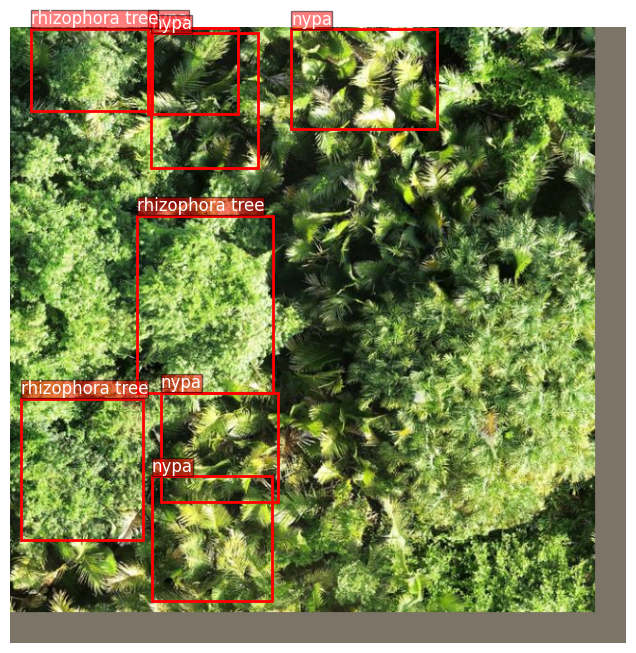

Total GT instances: 603
Total predictions:  265
⚠️ Jumlah prediksi dan ground-truth berbeda, lewati metrik classification.


In [41]:
# Cell 4 — Inference, Visualisasi, dan Evaluasi Metrik

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from retinanet.dataloader import UnNormalizer

# Fungsi menggambar caption pada gambar (matplotlib)
def draw_caption_plots(ax, box, caption):
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                         fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(x1, y1-5, caption, fontsize=12, color='white',
            bbox=dict(facecolor='red', alpha=0.5, pad=0))

# Fungsi evaluasi metrik
def evaluate_predictions(true_labels, pred_labels, pred_scores):
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=1)
    recall    = recall_score(true_labels, pred_labels, average='macro', zero_division=1)
    f1        = f1_score(true_labels, pred_labels, average='macro', zero_division=1)
    mAP       = average_precision_score(true_labels, pred_scores, average='macro')
    return precision, recall, f1, mAP

true_labels, pred_labels, pred_scores = [], [], []
visualized = False

for idx, data in enumerate(data_loader):
    imgs   = data['img'].to(device).float()
    # Ground-truth: ambil class_id dari data['annot']
    gt = data['annot'][0].cpu().numpy()    # N×5: [x1,y1,x2,y2,class_id]
    true_labels.extend(gt[:, -1].astype(int))

    with torch.no_grad():
        scores, classifications, anchors = model(imgs)
    
    # Prediksi dengan score > threshold
    idxs = np.where(scores.cpu() > 0.5)
    pred_labels.extend(classifications[idxs[0]].cpu().numpy())
    pred_scores.extend(scores[idxs].cpu().numpy())
    
    # Visualisasi hanya sekali
    if not visualized:
        unnormalize = UnNormalizer()
        img = imgs[0].cpu()
        img = (255 * unnormalize(img)).clamp(0, 255).byte().numpy()
        img = np.transpose(img, (1, 2, 0))
        
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(img)
        for j in idxs[0]:
            box        = anchors[j].cpu().numpy()
            label_name = dataset_test.labels[int(classifications[j])]
            draw_caption_plots(ax, box, label_name)
        ax.axis('off')
        plt.show()
        
        visualized = True  # jangan visualisasi ulang

# Setelah loop selesai, cek dulu jumlah prediksi vs GT
print(f"Total GT instances: {len(true_labels)}")
print(f"Total predictions:  {len(pred_labels)}")

if len(pred_labels) == 0:
    print("⚠️ Tidak ada prediksi di atas threshold; metrik tidak dapat dihitung.")
elif len(pred_labels) != len(true_labels):
    print("⚠️ Jumlah prediksi dan ground-truth berbeda, lewati metrik classification.")
else:
    p, r, f1, mAP = evaluate_predictions(true_labels, pred_labels, pred_scores)
    print(f"Precision: {p:.4f}")
    print(f"Recall:    {r:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"mAP:       {mAP:.4f}")


In [42]:
# Cell 5 — Hitung mAP dengan COCO API (tanpa indexing [0])

import sys
sys.path.append('/kaggle/working/pytorch-retinanet')

import torch
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Path ke anotasi test
ann_file = '/kaggle/working/annotations/instances_test.json'

# Load ground-truth COCO
coco_gt = COCO(ann_file)

# Siapkan list untuk menyimpan prediksi
coco_results = []

# Loop lewat data_loader
for idx, data in enumerate(data_loader):
    imgs = data['img'].to(device).float()
    image_id = dataset_test.image_ids[idx]
    
    with torch.no_grad():
        scores, classifications, anchors = model(imgs)
    
    # Convert ke numpy array (tanpa [0])
    scores = scores.cpu().numpy()            # shape (N_det,)
    classifications = classifications.cpu().numpy()  # shape (N_det,)
    anchors = anchors.cpu().numpy()          # shape (N_det, 4)
    
    # Simpan setiap deteksi di atas threshold
    for score, cls_id, box in zip(scores, classifications, anchors):
        if score < 0.05:
            continue
        x1, y1, x2, y2 = box
        coco_results.append({
            'image_id': int(image_id),
            'category_id': int(cls_id),
            'bbox': [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            'score': float(score)
        })

# Load prediksi ke format COCO
coco_dt = coco_gt.loadRes(coco_results)

# Inisialisasi dan jalankan COCOeval
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.params.imgIds = sorted(coco_gt.getImgIds())

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.87s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

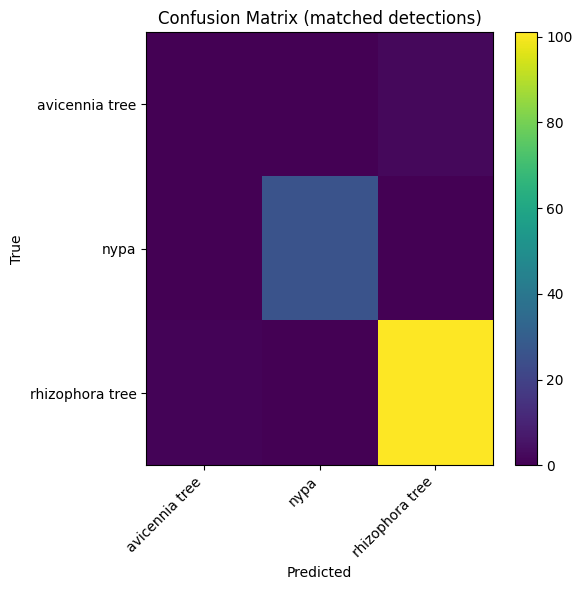

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from retinanet.dataloader import UnNormalizer

# Fungsi hitung IoU
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA); interH = max(0, yB - yA)
    interArea = interW * interH
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = areaA + areaB - interArea
    return interArea/unionArea if unionArea>0 else 0

# Threshold IoU untuk match
iou_thr = 0.5
true_matched, pred_matched = [], []

# Loop semua gambar di data_loader
for idx, data in enumerate(data_loader):
    imgs = data['img'].to(device).float()
    gt = data['annot'][0].cpu().numpy()      # GT: N×5 [x1,y1,x2,y2,class_id]
    with torch.no_grad():
        scores, cls_pred, anchors = model(imgs)
    scores = scores.cpu().numpy()
    cls_pred = cls_pred.cpu().numpy()
    anchors  = anchors.cpu().numpy()
    
    used = set()
    for pi, score in enumerate(scores):
        if score < 0.5: 
            continue
        best_iou = 0; best_gt = -1
        for gi, g in enumerate(gt):
            if gi in used: 
                continue
            iou = compute_iou(anchors[pi], g[:4])
            if iou>best_iou:
                best_iou, best_gt = iou, gi
        if best_iou>=iou_thr:
            true_matched.append(int(gt[best_gt, -1]))
            pred_matched.append(int(cls_pred[pi]))
            used.add(best_gt)

# Buat confusion matrix
labels = list(dataset_test.labels.values())  # e.g. ['1-QDa5-FSKD', 'avicennia tree', ...]
cm = confusion_matrix(true_matched, pred_matched, labels=range(len(labels)))

# Plot
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, aspect='auto')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (matched detections)')
fig.colorbar(im, ax=ax)
plt.tight_layout()

# Tampilkan
plt.show()

# Simpan ke file
fig.savefig('confusion_matrix.png')


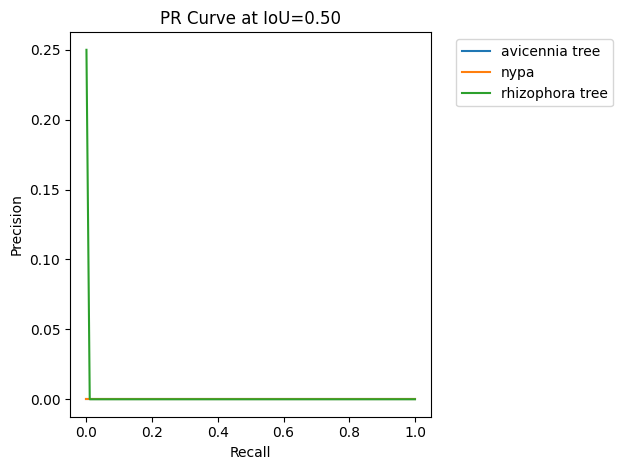

In [44]:
# Ambil data precision dari COCOeval (setelah .evaluate() dan .accumulate())
# precision: shape [TxRxKxAxM] T=10 IoU thresholds, R=101 recall thresholds, K=num classes, A=1 area, M=1 maxDets
precisions = coco_eval.eval['precision']  # numpy array

# Misal kita ambil IoU=0.50 (index 0), area 'all' (idx 0), maxDets=100 (idx 0)
# Plot PR curve untuk setiap kelas
import numpy as np, matplotlib.pyplot as plt

iou_idx = 0
area_idx = 0
maxdet_idx = 0
recall_thrs = np.linspace(0, 1, precisions.shape[1])

for k, class_name in dataset_test.labels.items():
    pr = precisions[iou_idx, :, k, area_idx, maxdet_idx]
    plt.plot(recall_thrs, pr, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve at IoU=0.50")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


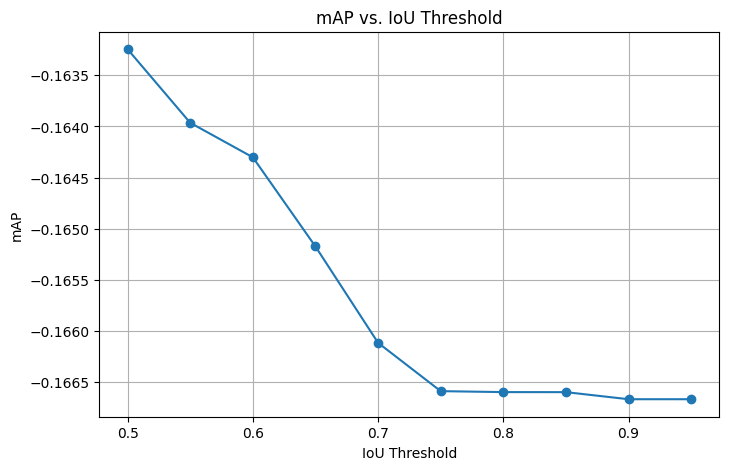

In [45]:
# Mean di axis recall (1), area (2), maxDet (3) → hasil: (T, K)
map_per_iou = precisions.mean(axis=(1, 2, 3))

# Mean untuk semua kelas → hasil: (T,)
mean_map = map_per_iou.mean(axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0.5, 0.95, len(mean_map)), mean_map, marker='o')
plt.title('mAP vs. IoU Threshold')
plt.xlabel('IoU Threshold')
plt.ylabel('mAP')
plt.grid(True)
plt.show()


In [46]:
plt.savefig('/kaggle/working/map_vs_iou.png')


<Figure size 640x480 with 0 Axes>

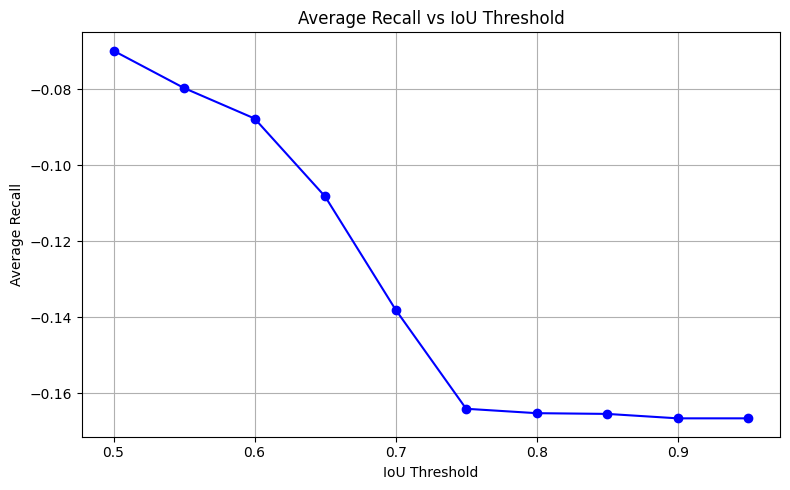

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan coco_eval sudah didefinisikan sebelumnya
# coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox') dst.

# Ambil daftar threshold IoU (biasanya dari 0.5 sampai 0.95 setiap 0.05)
iou_thrs = coco_eval.params.iouThrs  # shape: [T] biasanya 10 nilai

# Ambil recall array dari hasil evaluasi
# Bentuknya: [T, R, K, A, M] = IoU Thresholds, Recalls, Kategori, Area, MaxDets
recalls = coco_eval.eval['recall']  # biasanya shape: [10, 101, num_classes, 1, 1]

# Ambil rata-rata recall per IoU threshold: rata-rata seluruh kategori, area, dan maxDet
ar_per_iou = recalls.mean(axis=(1, 2, 3))  # hasil shape: [T]

# Plot AR vs IoU
plt.figure(figsize=(8, 5))
plt.plot(iou_thrs, ar_per_iou, marker='o', color='blue')
plt.title('Average Recall vs IoU Threshold')
plt.xlabel('IoU Threshold')
plt.ylabel('Average Recall')
plt.grid(True)
plt.tight_layout()

# Simpan hasil grafik
plt.savefig('/kaggle/working/ar_vs_iou.png')
plt.show()



In [48]:
# per‑class mAP, area='all', maxDets=100, averaged over IoU
class_labels = map_per_iou.mean(axis=0)  # shape (K,)

class_names = [dataset_test.labels[i] for i in range(len(map_per_class))]
plt.figure(figsize=(6,4))
plt.plot(class_names, map_per_class)
plt.xlabel("mAP")
plt.title("mAP per Class")
plt.tight_layout()
plt.show()


NameError: name 'map_per_class' is not defined

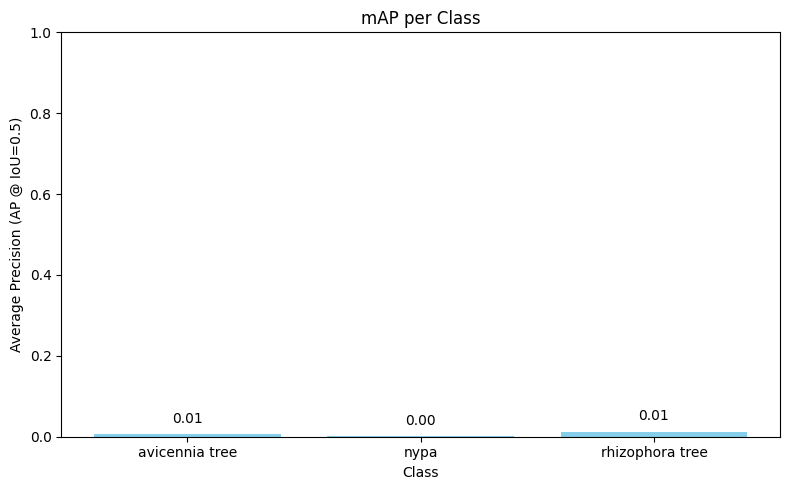

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Daftar nama kelas dari label map
class_names = ['avicennia tree', 'nypa', 'rhizophora tree']  # urut sesuai label map (tanpa '1-QDa5-FSKD')

# Ambil AP per kelas dari COCOeval
precisions = coco_eval.eval['precision']  # shape: [T, R, K, A, M]
iou_threshold_idx = 0  # IoU = 0.5
area_idx = 0          # area = all
max_det_idx = 2       # maxDets = 100

ap_per_class = []
for class_idx in range(len(class_names)):
    precision = precisions[iou_threshold_idx, :, class_idx, area_idx, max_det_idx]
    precision = precision[precision > -1]
    ap = np.mean(precision) if precision.size else 0
    ap_per_class.append(ap)

# Plot grafik
plt.figure(figsize=(8, 5))
bars = plt.bar(class_names, ap_per_class, color='skyblue')
plt.xlabel("Class")
plt.ylabel("Average Precision (AP @ IoU=0.5)")
plt.title("mAP per Class")
plt.ylim(0, 1.0)

# Tambahkan nilai di atas bar
for bar, ap in zip(bars, ap_per_class):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{ap:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [52]:
plt.savefig("map_per_class.png")


<Figure size 640x480 with 0 Axes>

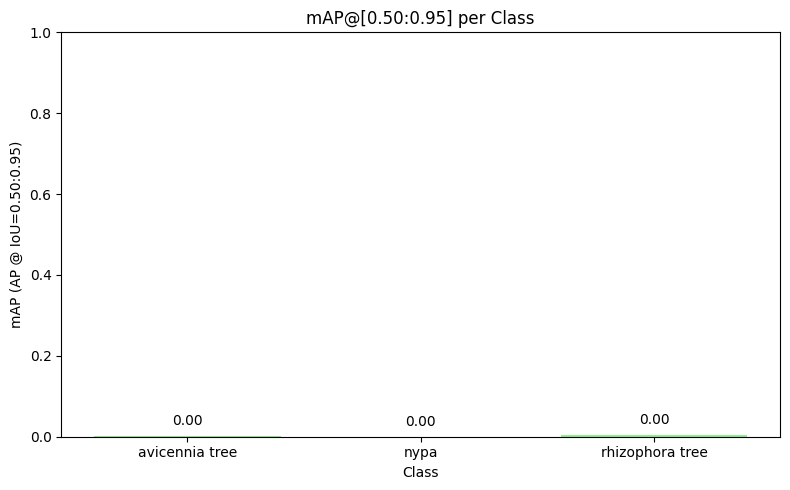

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Daftar nama kelas (disesuaikan urutan label map)
class_names = ['avicennia tree', 'nypa', 'rhizophora tree']  # pastikan urut sesuai label map

# Ambil precision dari evaluasi COCO
precisions = coco_eval.eval['precision']  # shape: [T, R, K, A, M]
area_idx = 0      # all area
max_det_idx = 2   # maxDets = 100

# Hitung mAP@[0.5:0.95] per class
map_per_class = []
for class_idx in range(len(class_names)):
    precision = precisions[:, :, class_idx, area_idx, max_det_idx]  # semua IoU
    precision = precision[precision > -1]  # filter nilai valid
    ap = np.mean(precision) if precision.size else 0
    map_per_class.append(ap)

# Plot grafik
plt.figure(figsize=(8, 5))
bars = plt.bar(class_names, map_per_class, color='lightgreen')
plt.xlabel("Class")
plt.ylabel("mAP (AP @ IoU=0.50:0.95)")
plt.title("mAP@[0.50:0.95] per Class")
plt.ylim(0, 1.0)

# Tambahkan nilai di atas bar
for bar, ap in zip(bars, map_per_class):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{ap:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("map_50_95_per_class.png")
plt.show()


In [53]:
from IPython.display import Image

# Menampilkan gambar loss_map_curve.png
Image(filename="/kaggle/working/loss_map_curve.png")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/loss_map_curve.png'